<a href="https://colab.research.google.com/github/felicityogoke/HealthCare-Sentiment-Analysis/blob/main/Sentiment_analysis_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Collection


In [56]:
# # Mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [58]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [59]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, LSTM, Dropout, Dense

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from tensorflow.keras.preprocessing.sequence import pad_sequences

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

import re
import string
import os
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet


nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer


color = sns.color_palette()
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


##Exploratory Analysis

###Load data set

In [60]:
# Load dataset file into a Pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/webmd.csv")
# Output first five rows
df.head()

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1
2,65-74,Other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to ov...,3,Female,,0
3,75 or over,Other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0
4,35-44,Other,1/6/2009,warfarin (bulk) 100 % powder,144731,1,1,My grandfather was prescribed this medication ...,1,Male,,1


In [61]:
# Map the numerical ratings to corresponding labels
label_map = {1: 'Negative', 2: 'Negative', 3: 'Neutral', 4: 'Positive', 5: 'Positive'}
df['sentiment'] = df['Satisfaction'].map(label_map)

In [62]:
#df= df.loc[df['Drug'].isin(['cymbalta','lisinopril solution', 'lisinopril','lexapro','hydrocodone-acetaminophen','effexor xr','lyrica','tramadol hcl er', 'tramadol hcl', 'zoloft'])]

In [63]:
df.shape

(362806, 13)

In [64]:
# create a new dataframe with only the reviews column and sentiment column
df = df.loc[:, ['Reviews', 'sentiment']]

In [65]:
df.head()

,Reviews,sentiment
0,I'm a retired physician and of all the meds I ...,Positive
1,cleared me right up even with my throat hurtin...,Positive
2,why did my PTINR go from a normal of 2.5 to ov...,Neutral
3,FALLING AND DON'T REALISE IT,Negative
4,My grandfather was prescribed this medication ...,Negative


In [66]:
# Drop all rows with a rating of 3
df = df.loc[df['sentiment'] != 'Neutral']


###View Dataset Class distribution

In [67]:
# Assuming you have a DataFrame 'df_train' with a column 'sentiment' representing the class labels

# Count the occurrences of each sentiment class
sentiment_counts = df['sentiment'].value_counts()

# Calculate the percentage of positive and negative classes
positive_percentage = (sentiment_counts['Positive'] / len(df)) * 100
negative_percentage = (sentiment_counts['Negative'] / len(df)) * 100

# Print the percentages
print("Positive Percentage:", positive_percentage)
print("Negative Percentage:", negative_percentage)


Positive Percentage: 56.184516037741915
Negative Percentage: 43.814519189333474


###Determine size of data set

In [68]:
df = df.loc[:80000,:]

In [69]:
df.shape

(67937, 2)

In [70]:
df['Reviews'].apply(lambda x:len(str(x).split())).max()

424

###Train Test Split

In [71]:
# Split the data into training and testing sets (70% for training and 30% for testing)
y= df['sentiment']
df_train, df_test = train_test_split(df, test_size=0.3,stratify=y)

# Split the training data into training and validation sets (50% for training and 50% for validation)
#df_train, df_val = train_test_split(df_train, test_size=0.5, random_state=42)


###Removing Duplicates and Empty rows

In [72]:
#print the number of null values in each column
df_test.isnull().sum()

Reviews      3
sentiment    0
dtype: int64

In [73]:
df_train = df_train.dropna()
df_test = df_train.dropna()

In [74]:
#removing duplicated values
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [75]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_train[df_train['Reviews'].duplicated() == True]

,Reviews,sentiment
63,,Negative
1100,none,Negative
5504,side effects,Positive
6012,back pain,Negative
8765,weight gain,Negative
9214,headaches,Positive
10699,ok,Negative
11602,it helps,Negative
12749,constipation,Negative
14251,dizziness,Positive


In [76]:
#print some of those rows to check
df_train[df_train['Reviews'] == df_train.iloc[3548]['Reviews']]

,Reviews,sentiment
3548,it has helpped control my pain and given me a ...,Positive


In [77]:
#removing duplicated text
index = df_train[df_train['Reviews'].duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

###Removing Stopwords and converting to lower cases

In [78]:
import nltk
from nltk.corpus import stopwords

def data_cleaning(raw_data):
    raw_data = raw_data.translate(str.maketrans('', '', string.punctuation + string.digits))
    words = raw_data.lower().split()
    stop_words = set(stopwords.words("english"))
    useful_words = [w for w in words if not w in stop_words]
    return " ".join(useful_words)



In [79]:
df_train['Reviews']= df_train['Reviews'].apply(data_cleaning)

In [80]:
df_test["Reviews"]=df_test["Reviews"].apply(data_cleaning)

In [81]:
df_test['Reviews']

3014     work well fibromyalgia still pain mean sever pain
73644    felt better since taking supplement seen reduc...
382      read reviews decided side effects worth taking...
47042                                      lower pvcs much
17102    imediately taking lisinopril developed cough s...
                               ...                        
53829    drug made life tolerable problems stem severe ...
32143    ive medication months noticeable hair loss rea...
59207    never really takes pain away makes possible fu...
68132    taking many different pain meds due chronic pa...
6        havent gotten pregnant job switched brand anot...
Name: Reviews, Length: 47549, dtype: object

In [82]:
df_train['Reviews']

0        work well fibromyalgia still pain mean sever pain
1        felt better since taking supplement seen reduc...
2        read reviews decided side effects worth taking...
3                                          lower pvcs much
4        imediately taking lisinopril developed cough s...
                               ...                        
31724    put medication increase seratonin levels alter...
31725    balance problems drowsy time gained lbs little...
31726    th prep colonoscopy scheduled tomorrow say mov...
31727    taking many different pain meds due chronic pa...
31728    havent gotten pregnant job switched brand anot...
Name: Reviews, Length: 31729, dtype: object

###Visualizing the words majorly found through Wordclouds

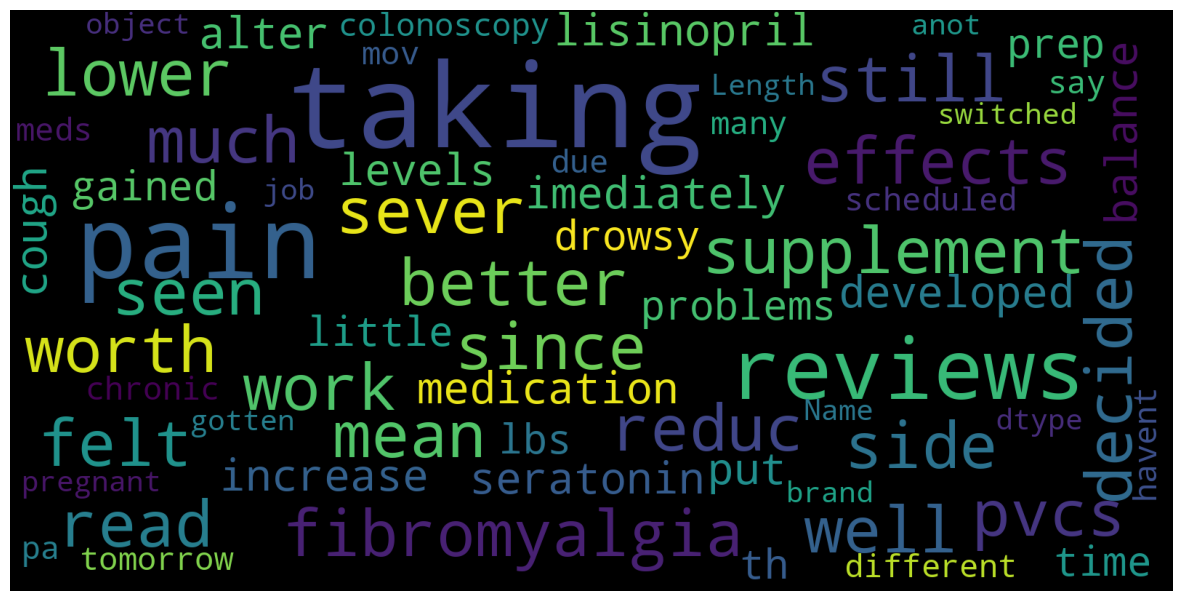

In [83]:


def generate_wordcloud(data, title=None):
    stopwords_set = set(stopwords.words('english'))
    wordcloud = WordCloud(
        stopwords=stopwords_set,
        max_words=100,
        max_font_size=40,
        scale=4).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

generate_wordcloud(df_train['Reviews'])


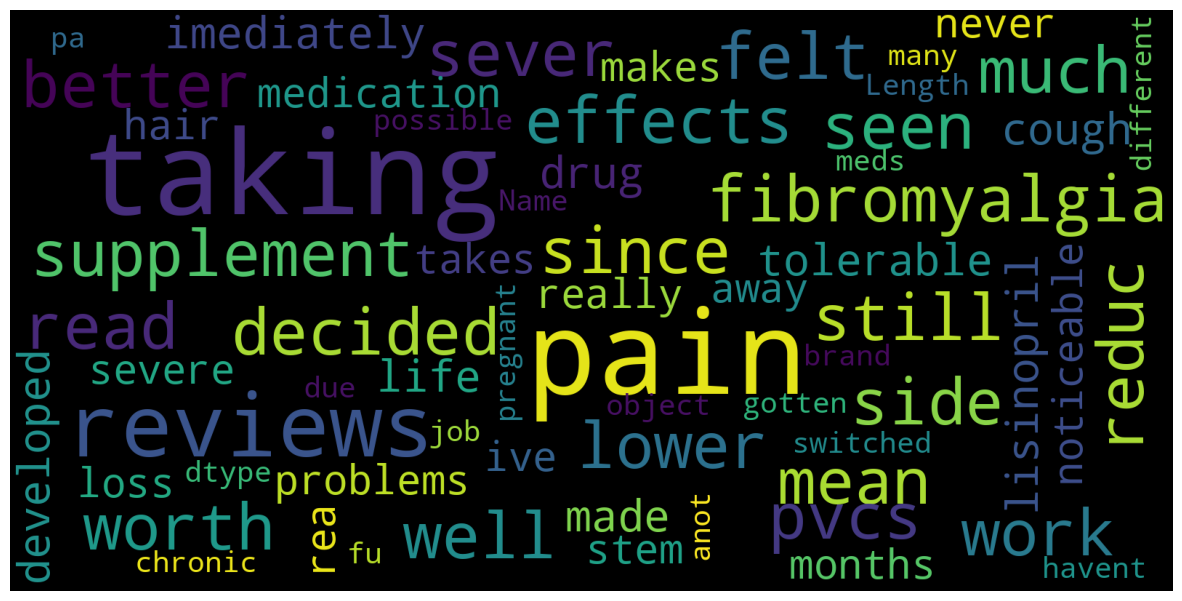

In [84]:
generate_wordcloud(df_test["Reviews"])

###Lemmatization

####Lemmatization

In [85]:
lemmatizer = WordNetLemmatizer()

# Define a function for lemmatization
def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

In [86]:
# Apply lemmatization to the 'Reviews' column in df_train
df_train['Reviews'] = df_train['Reviews'].apply(lemmatize_text)


###Visualizing class distribution

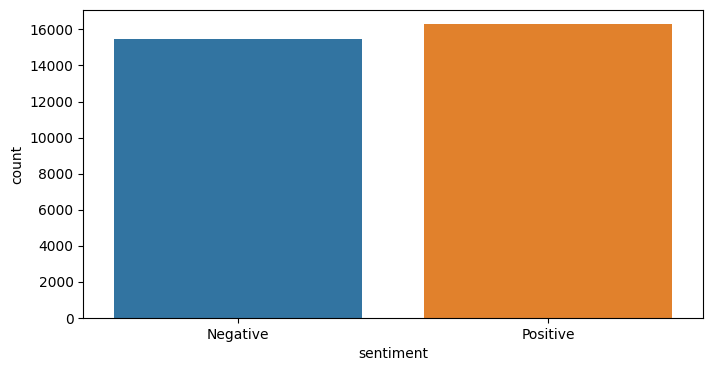

In [87]:
plt.figure(figsize=(8,4))
sns.countplot(x='sentiment', data=df_train);

## Feature extraction and Model preparation


###Encoding and Transforming

In [88]:
xtrain = df_train['Reviews']
ytrain = df_train['sentiment']

In [89]:
xtest = df_test['Reviews']
ytest = df_test['sentiment']

In [90]:
print(ytrain)

0        Negative
1        Positive
2        Negative
3        Negative
4        Negative
           ...   
31724    Positive
31725    Negative
31726    Negative
31727    Negative
31728    Negative
Name: sentiment, Length: 31729, dtype: object


In [91]:
le = LabelEncoder()
ytrain = df_train.sentiment.values
ytrain = le.fit_transform(ytrain)

In [92]:
print(ytrain)

[0 1 0 ... 0 0 0]


In [93]:
print(ytest)

3014     Negative
73644    Positive
382      Negative
47042    Negative
17102    Negative
           ...   
53829    Positive
32143    Negative
59207    Negative
68132    Negative
6        Negative
Name: sentiment, Length: 47549, dtype: object


In [94]:
ytest = df_test.sentiment.values
ytest= le.fit_transform(ytest)

In [95]:
print(ytest)

[0 1 0 ... 0 0 0]


In [96]:
xtrain.shape, ytrain.shape

((31729,), (31729,))

###Tokenizing

In [97]:
# using keras tokenizer here
token = text.Tokenizer(num_words=10000)
max_len = 600

token.fit_on_texts(list(xtrain))
xtrain_seq = token.texts_to_sequences(xtrain)
xtest_seq = token.texts_to_sequences(xtest)


#zero pad the sequences
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_len)
xtest_pad = pad_sequences(xtest_seq, maxlen=max_len)

word_index = token.word_index

In [98]:
print(len(word_index))

40196


###Creating Embedding Matrix

In [99]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('/content/drive/MyDrive/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196017it [02:58, 12329.87it/s]

Found 2196016 word vectors.


In [100]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 40196/40196 [00:00<00:00, 371698.46it/s]


##MODEL TRAINING


###Callbacks for early stopping and saving model checkpoints

In [101]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs={}):
        if logs.get('accuracy') > 0.95:
            print('\n Stopped Training!\n')
            self.model.stop_training = True


def train_model(model, model_name, n_epochs, batch_size, X_data, y_data, validation_split):
    checkpoint_path = model_name+"_cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,  save_weights_only=True, verbose=1)
    callbacks = myCallback()
    history = model.fit(
        X_data,
        y_data,
        steps_per_epoch=batch_size,
        epochs=n_epochs,
        validation_split=validation_split,
        verbose=1,
        callbacks=[cp_callback]
    )
    return history

### Evaluation metrics function

In [102]:


def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



In [103]:
def predict_func(model):
  prediction = model.predict(xtest_pad)

  y_pred = (prediction > 0.5)


  cf_matrix = confusion_matrix(y_pred, ytest)
  f1_score_calc = cf_matrix[0][0] / (cf_matrix[0][0] + 0.5 * (cf_matrix[0][1] + cf_matrix[1][0]))
  print('F1-score: %.3f' % f1_score_calc)
  print("Confusion Matrix : ", cf_matrix)
  plot_confusion_matrix(cf_matrix)
  return f1_score_calc

In [104]:
def generate_graph(history):
    plt.plot(history.history['accuracy'], 'b')
    plt.plot(history.history['val_accuracy'], 'r')
    plt.title('Model Accuracy'),
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

###Simple RNN

In [ ]:
class Model_A():
  def __new__(self):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                        300,
                        weights=[embedding_matrix],
                        input_length=max_len,
                        trainable=False))

    model.add(SimpleRNN(89))
    model.add(Dropout(0.2789))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


    return model

In [ ]:
model_A = Model_A()
history_A = train_model(model_A, "model_A", 10,64, xtrain_pad, ytrain, 0.2)

Epoch 1/10
64/64 [==============================] - ETA: 0s - loss: 0.6483 - accuracy: 0.6311
Epoch 1: saving model to model_A_cp-0001.ckpt
64/64 [==============================] - 38s 493ms/step - loss: 0.6483 - accuracy: 0.6311 - val_loss: 0.5875 - val_accuracy: 0.6900
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.5758 - accuracy: 0.7067
Epoch 2: saving model to model_A_cp-0002.ckpt
64/64 [==============================] - 32s 499ms/step - loss: 0.5758 - accuracy: 0.7067 - val_loss: 0.5521 - val_accuracy: 0.7198
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.6228 - accuracy: 0.6555
Epoch 3: saving model to model_A_cp-0003.ckpt
64/64 [==============================] - 31s 482ms/step - loss: 0.6228 - accuracy: 0.6555 - val_loss: 0.6760 - val_accuracy: 0.5782
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 0.6494 - accuracy: 0.6167
Epoch 4: saving model to model_A_cp-0004.ckpt
64/64 [==============================] - 31s

1486/1486 [==============================] - 67s 45ms/step
F1-score: 0.698
Confusion Matrix :  [[13577  4021]
 [ 7713 22239]]


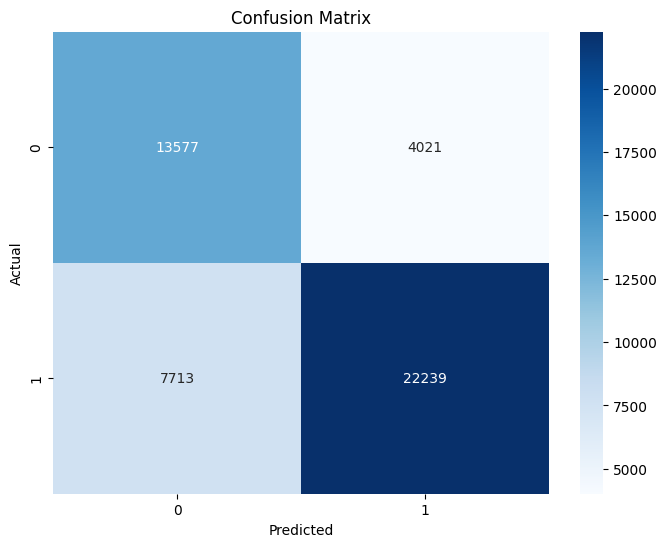

In [ ]:
model_A_score = predict_func(model_A)

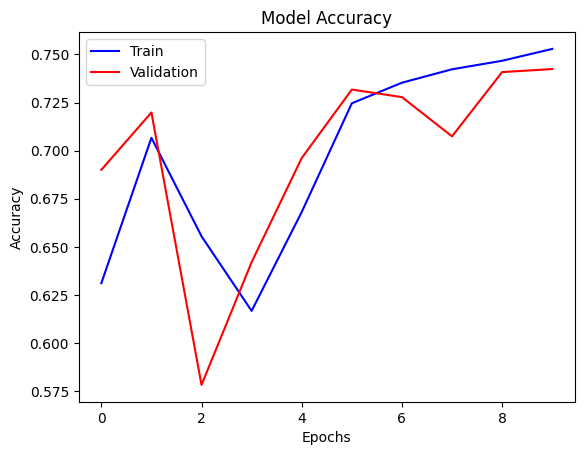

In [ ]:
generate_graph(history_A)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Assuming you have predictions and ground truth labels for the test data
y_pred = model_A.predict(xtest_pad)# Replace `model` with your trained model
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions if needed

# Accuracy
accuracy = accuracy_score(ytest, y_pred_binary)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(ytest, y_pred_binary)
print("Precision:", precision)

# Recall
recall = recall_score(ytest, y_pred_binary)
print("Recall:", recall)

# F1-Score
f1 = f1_score(ytest, y_pred_binary)
print("F1-Score:", f1)

# Area Under ROC Curve (AUROC)
auroc = roc_auc_score(ytest, y_pred)
print("AUROC:", auroc)


1486/1486 [==============================] - 68s 45ms/step
Accuracy: 0.7532281808622503
Precision: 0.7424879807692307
Recall: 0.8468773800456969
F1-Score: 0.7912545363979221
AUROC: 0.813529282454567


In [ ]:
print(model_A.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 600, 300)          11973900  
                                                                 
 simple_rnn (SimpleRNN)      (None, 89)                34710     
                                                                 
 dropout (Dropout)           (None, 89)                0         
                                                                 
 dense (Dense)               (None, 1)                 90        
                                                                 
Total params: 12,008,700
Trainable params: 34,800
Non-trainable params: 11,973,900
_________________________________________________________________
None


###LSTM MODEL

In [ ]:
class Model_B():
    def __new__(self):
        model = Sequential()
        model.add(Embedding(len(word_index) + 1,
                        300,
                        weights=[embedding_matrix],
                        input_length=max_len,
                        trainable=False))

        model.add(LSTM(units=61, dropout=0.2455))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model


In [ ]:
model_B = Model_B()
print(model_B.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 600, 300)          11997300  
                                                                 
 lstm (LSTM)                 (None, 61)                88328     
                                                                 
 dense (Dense)               (None, 1)                 62        
                                                                 
Total params: 12,085,690
Trainable params: 88,390
Non-trainable params: 11,997,300
_________________________________________________________________
None


In [ ]:
model_B = Model_B()
history_B = train_model(model_B, "model_B", 10, 64, xtrain_pad, ytrain, 0.2)

Epoch 1/10
64/64 [==============================] - ETA: 0s - loss: 0.6026 - accuracy: 0.6661
Epoch 1: saving model to model_B_cp-0001.ckpt
64/64 [==============================] - 10s 109ms/step - loss: 0.6026 - accuracy: 0.6661 - val_loss: 0.5318 - val_accuracy: 0.7325
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.5327 - accuracy: 0.7298
Epoch 2: saving model to model_B_cp-0002.ckpt
64/64 [==============================] - 7s 108ms/step - loss: 0.5327 - accuracy: 0.7298 - val_loss: 0.5064 - val_accuracy: 0.7491
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.5029 - accuracy: 0.7505
Epoch 3: saving model to model_B_cp-0003.ckpt
64/64 [==============================] - 6s 101ms/step - loss: 0.5029 - accuracy: 0.7505 - val_loss: 0.4946 - val_accuracy: 0.7616
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 0.4838 - accuracy: 0.7638
Epoch 4: saving model to model_B_cp-0004.ckpt
64/64 [==============================] - 6s 10

1486/1486 [==============================] - 12s 8ms/step
F1-score: 0.742
Confusion Matrix :  [[18013  9152]
 [ 3355 17029]]


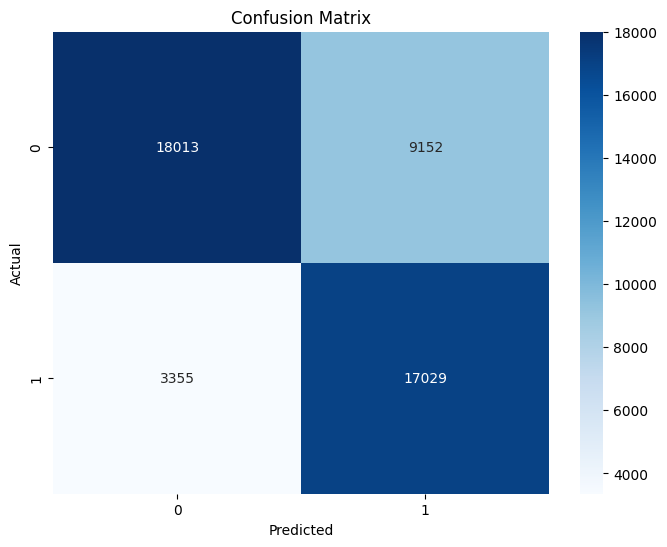

In [ ]:
model_B_score = predict_func(model_B)

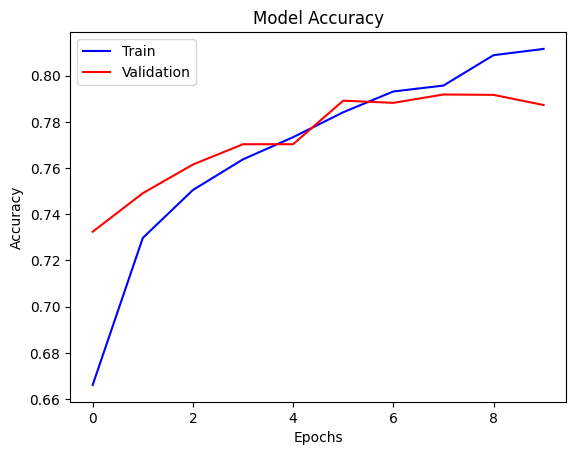

In [ ]:
generate_graph(history_B)

In [ ]:

# Assuming you have predictions and ground truth labels for the test data
y_pred = model_B.predict(xtest_pad)# Replace `model` with your trained model
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions if needed

# Accuracy
accuracy = accuracy_score(ytest, y_pred_binary)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(ytest, y_pred_binary)
print("Precision:", precision)

# Recall
recall = recall_score(ytest, y_pred_binary)
print("Recall:", recall)

# F1-Score
f1 = f1_score(ytest, y_pred_binary)
print("F1-Score:", f1)

# Area Under ROC Curve (AUROC)
auroc = roc_auc_score(ytest, y_pred)
print("AUROC:", auroc)

1486/1486 [==============================] - 11s 7ms/step
Accuracy: 0.7369660770994132
Precision: 0.835410125588697
Recall: 0.6504335204919598
F1-Score: 0.731407709653173
AUROC: 0.8754167959576858


###Bi directional LSTM

In [56]:
class Model_C():
  def __new__(self):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                        300,
                        weights=[embedding_matrix],
                        input_length=max_len,
                        trainable=False))

    model.add(Bidirectional(LSTM(units=104, dropout=0.27)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [57]:
model_C = Model_C()
print(model_C.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 600, 300)          12016200  
                                                                 
 bidirectional (Bidirectiona  (None, 208)              336960    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 209       
                                                                 
Total params: 12,353,369
Trainable params: 337,169
Non-trainable params: 12,016,200
_________________________________________________________________
None


In [58]:
model_C = Model_C()
history_C = train_model(model_C, "model_C", 10, 64, xtrain_pad, ytrain, 0.2)


Epoch 1/10
64/64 [==============================] - ETA: 0s - loss: 0.6007 - accuracy: 0.6656
Epoch 1: saving model to model_C_cp-0001.ckpt
64/64 [==============================] - 29s 304ms/step - loss: 0.6007 - accuracy: 0.6656 - val_loss: 0.5389 - val_accuracy: 0.7337
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.5360 - accuracy: 0.7295
Epoch 2: saving model to model_C_cp-0002.ckpt
64/64 [==============================] - 18s 288ms/step - loss: 0.5360 - accuracy: 0.7295 - val_loss: 0.5069 - val_accuracy: 0.7498
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.5047 - accuracy: 0.7499
Epoch 3: saving model to model_C_cp-0003.ckpt
64/64 [==============================] - 18s 280ms/step - loss: 0.5047 - accuracy: 0.7499 - val_loss: 0.4978 - val_accuracy: 0.7566
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 0.4865 - accuracy: 0.7586
Epoch 4: saving model to model_C_cp-0004.ckpt
64/64 [==============================] - 18s

1486/1486 [==============================] - 24s 15ms/step
F1-score: 0.751
Confusion Matrix :  [[18548  9554]
 [ 2741 16705]]


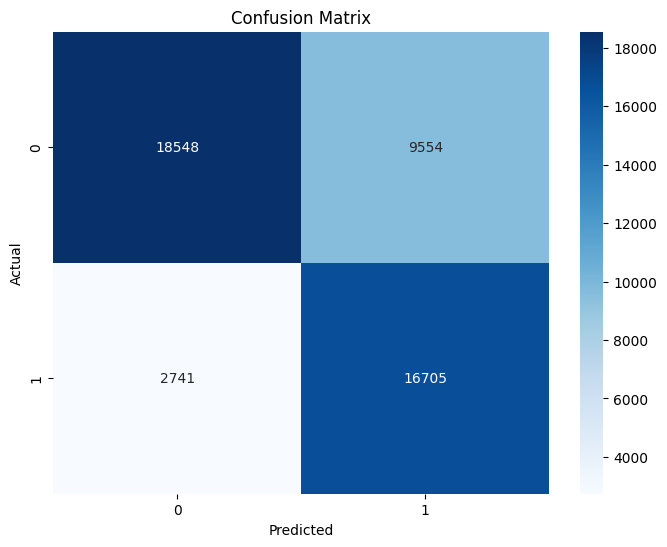

In [59]:
model_C_score = predict_func(model_C)

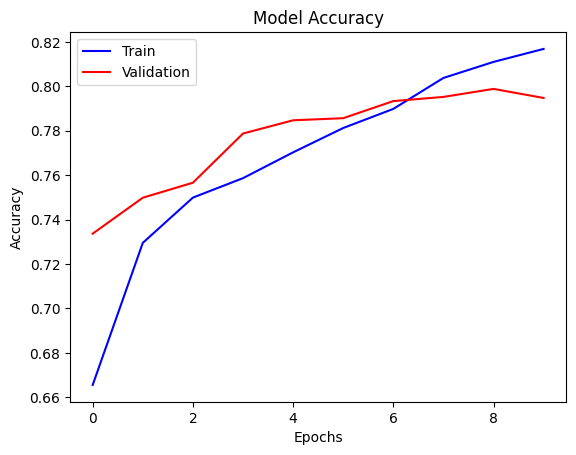

In [60]:
generate_graph(history_C)

In [ ]:
y_pred = model_C.predict(xtest_pad)# Replace `model` with your trained model
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions if needed


In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Accuracy
accuracy = accuracy_score(ytest, y_pred_binary)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(ytest, y_pred_binary)
print("Precision:", precision)

# Recall
recall = recall_score(ytest, y_pred_binary)
print("Recall:", recall)

# F1-Score
f1 = f1_score(ytest, y_pred_binary)
print("F1-Score:", f1)

# Area Under ROC Curve (AUROC)
auroc = roc_auc_score(ytest, y_pred)
print("AUROC:", auroc)

Accuracy: 0.7414191974425843
Precision: 0.8590455620693201
Recall: 0.6361628394074412
F1-Score: 0.7309922327972869
AUROC: 0.8844787904851633


### GRU Model

In [105]:
class Model_D():
  def __new__(self):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                        300,
                        weights=[embedding_matrix],
                        input_length=max_len,
                        trainable=False))
    model.add(SpatialDropout1D(0.64))
    model.add(GRU(363))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [106]:
model_D = Model_D()
print(model_D.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 600, 300)          12059100  
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 600, 300)         0         
 lDropout1D)                                                     
                                                                 
 gru_2 (GRU)                 (None, 363)               724185    
                                                                 
 dense_2 (Dense)             (None, 1)                 364       
                                                                 
Total params: 12,783,649
Trainable params: 724,549
Non-trainable params: 12,059,100
_________________________________________________________________
None


In [107]:
model_D = Model_D()
history_D = train_model(model_D, "model_D", 10, 64, xtrain_pad, ytrain, 0.2)


Epoch 1/10
64/64 [==============================] - ETA: 0s - loss: 0.6401 - accuracy: 0.6320
Epoch 1: saving model to model_D_cp-0001.ckpt
64/64 [==============================] - 33s 488ms/step - loss: 0.6401 - accuracy: 0.6320 - val_loss: 0.5641 - val_accuracy: 0.7127
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.5872 - accuracy: 0.6890
Epoch 2: saving model to model_D_cp-0002.ckpt
64/64 [==============================] - 30s 477ms/step - loss: 0.5872 - accuracy: 0.6890 - val_loss: 0.5469 - val_accuracy: 0.7197
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.5605 - accuracy: 0.7071
Epoch 3: saving model to model_D_cp-0003.ckpt
64/64 [==============================] - 30s 476ms/step - loss: 0.5605 - accuracy: 0.7071 - val_loss: 0.5424 - val_accuracy: 0.7225
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 0.5409 - accuracy: 0.7228
Epoch 4: saving model to model_D_cp-0004.ckpt
64/64 [==============================] - 31s

1486/1486 [==============================] - 26s 17ms/step
F1-score: 0.729
Confusion Matrix :  [[18170 10385]
 [ 3120 15874]]


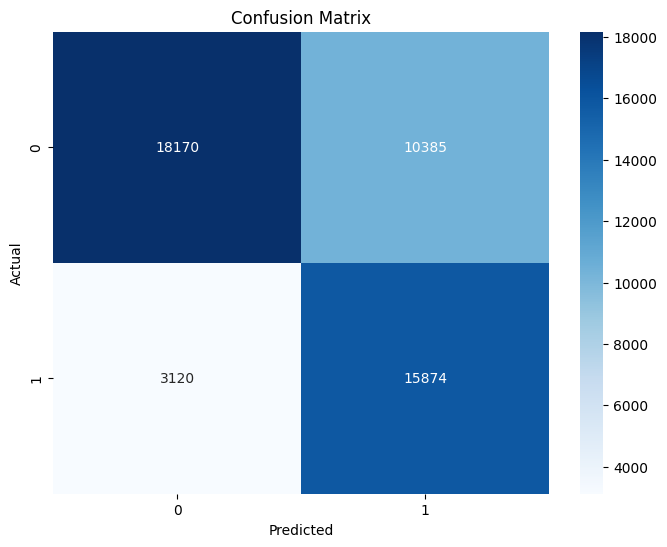

In [108]:
model_D_score = predict_func(model_D)

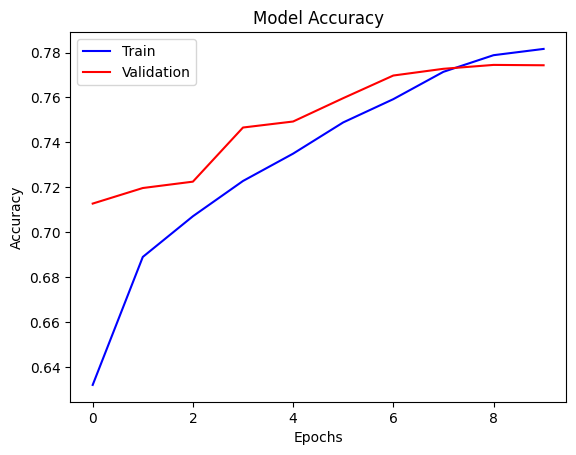

In [109]:
generate_graph(history_D)

In [110]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Assuming you have predictions and ground truth labels for the test data
y_pred = model_D.predict(xtest_pad)# Replace `model` with your trained model
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions if needed

# Accuracy
accuracy = accuracy_score(ytest, y_pred_binary)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(ytest, y_pred_binary)
print("Precision:", precision)

# Recall
recall = recall_score(ytest, y_pred_binary)
print("Recall:", recall)

# F1-Score
f1 = f1_score(ytest, y_pred_binary)
print("F1-Score:", f1)

# Area Under ROC Curve (AUROC)
auroc = roc_auc_score(ytest, y_pred)
print("AUROC:", auroc)

1486/1486 [==============================] - 25s 17ms/step
Accuracy: 0.7159772024648258
Precision: 0.8357376013477941
Recall: 0.6045165467077954
F1-Score: 0.701566746956003
AUROC: 0.8612559623253643


##Model Evaluation

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_model_scores(model_scores):
    plt.figure(figsize=(7, 7))
    plt.title('Comparison of models')
    plt.xlabel('Models')
    plt.ylabel('Model Score')
    plt.xticks(rotation=60)
    plt.yticks(rotation=60)

    plots = sns.barplot(x=list(model_scores.keys()), y=list(model_scores.values()))

    for p in plots.patches:
        plots.annotate(format(p.get_height(), '.3f'),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center',
                       xytext=(0, 9),
                       textcoords='offset points')

    plt.show()


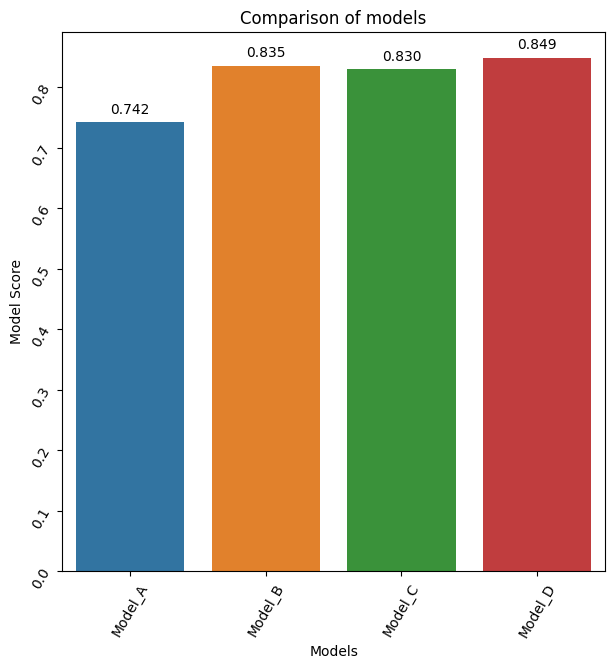

In [6]:
results_precision = {"Model_A": 0.7424879807692307,
                      "Model_B": 0.835410125588697,
                      "Model_C": 0.830076745609492,
                      "Model_D": 0.8485133193323754}


plot_model_scores(results_precision)

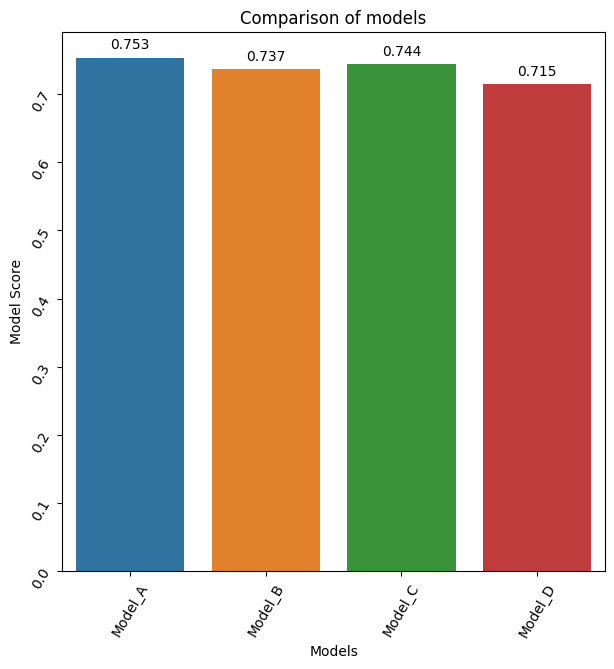

In [7]:
results_accuracy = {"Model_A": 0.7532281808622503,
                      "Model_B":0.7369660770994132,
                      "Model_C": 0.7442638120675513,
                      "Model_D": 0.7146312225283392}


plot_model_scores(results_accuracy)

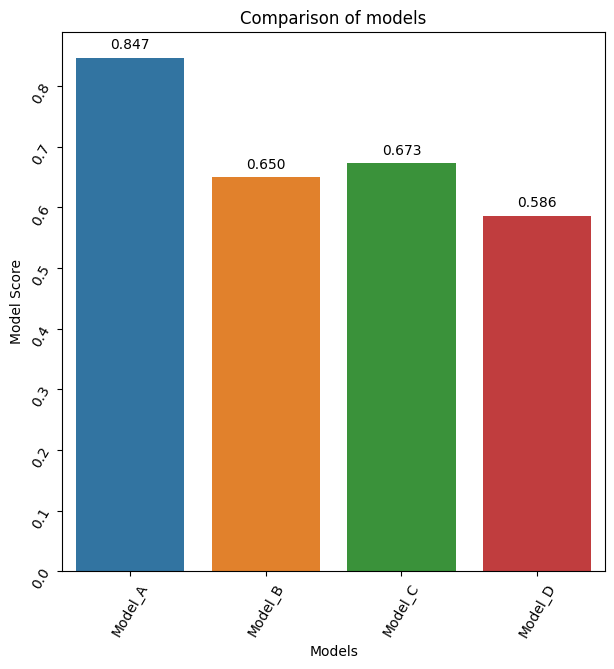

In [8]:
results_recall = {"Model_A": 0.8468773800456969,
                      "Model_B":0.6504335204919598,
                      "Model_C": 0.6733890989648982,
                      "Model_D": 0.5864176311065277}


plot_model_scores(results_recall)

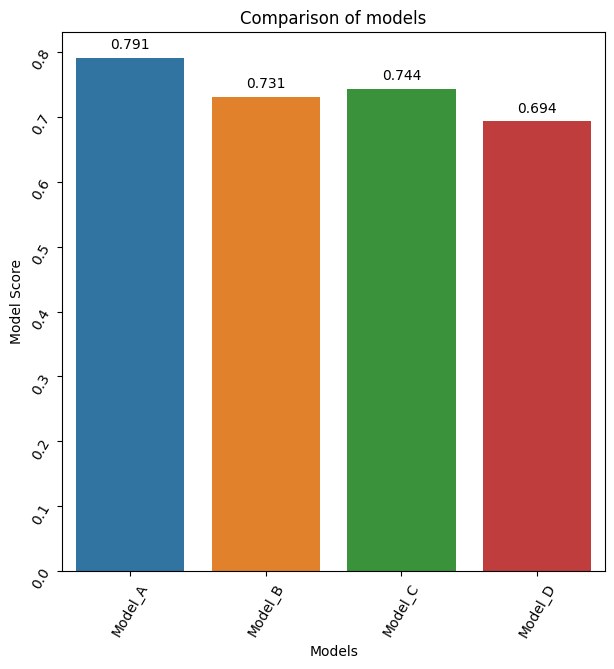

In [9]:
results_F1 = {"Model_A": 0.7912545363979221,
                      "Model_B":0.731407709653173,
                      "Model_C": 0.7435681147195277,
                      "Model_D": 0.6935290796160362}


plot_model_scores(results_F1)

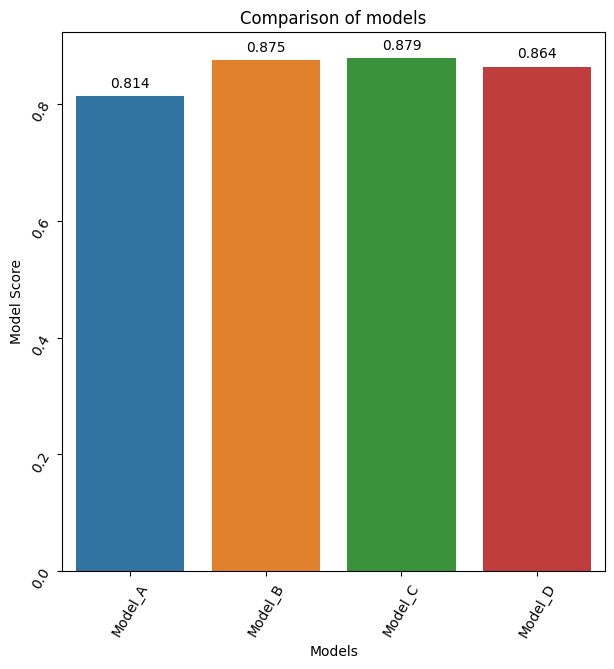

In [10]:
results_AUROC = {"Model_A": 0.813529282454567,
                      "Model_B":0.8754167959576858,
                      "Model_C": 0.8793615832905652,
                      "Model_D": 0.8641177127216401}


plot_model_scores(results_AUROC)